# Лекция 4: Эмбеддинг

__Автор: Сергей Вячеславович Макрушин__ e-mail: SVMakrushin@fa.ru 

Финансовый универсиет, 2021 г. 

При подготовке лекции использованы материалы:
* ...
* v 0.3 01.04.21
* v 0.4 04.04.21

In [1]:
# загружаем стиль для оформления презентации
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen("file:./lec_v2.css")
HTML(html.read().decode('utf-8'))

## Разделы: <a class="anchor" id="разделы"></a>
* [Загрузка и преобразование данных](#загрузка)
* [Нормализация](#нормализация)
* [Оценка качества моделей](#качество)
* [Решение задачи двухклассовой классификации](#двухклассовая)
    * [Создание тензоров](#создание-тензоров)
    * [Операции с тензорами](#операции-тензоры)    
        * [Арифметические операции и математические функции:](#aрифметические)        
        * [Операции, изменяющие размер тензора](#размер)        
        * [Операции агрегации](#агрегации)        
        * [Матричные операции](#aрифметические)                
-

* [к оглавлению](#разделы)

---
## Нормализация <a class="anchor" id="нормализация"></a>
* [к оглавлению](#разделы)

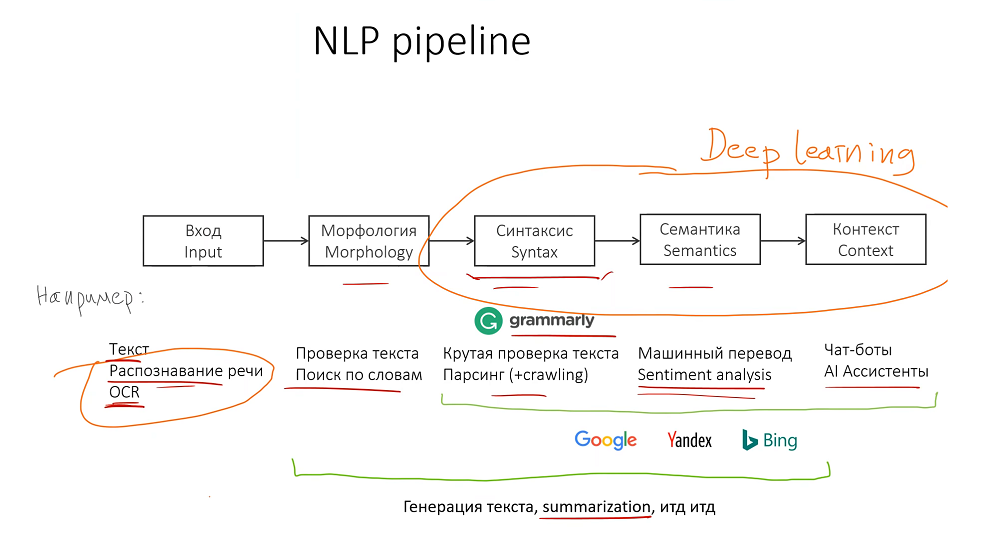

__Мотивация для построения эмбеддинга__

_Эмбеддинг (embedding) ~ векторное представление_

<b class="b">Problem:</b> Решение задачи машинного обучения (с учителем) требует конструирования признаков для каждой конкретной задачи!

<center>         
    <img src="./img/tcn_emb1_int1.png" alt="Граф зависимостей задач" style="width: 500px;"/>
    <b>Этапы решения задачи машинного обучения</b>
</center>


* __upstream processing__ - pre-processing
* __downstream__ - employed after data preprocessing
    * Вариант 1: "Downstream estimators"  is a general term referring to the estimators employed after data preprocessing step.):
    * Вариант 2: "Downstream tasks is what the field calls those supervised-learning tasks that utilize a pre-trained model or component"
    
<b class="b">Goal:</b>
* Эффективное извлечение признаков (в задачи обучения без учителя) для задач машинного обучения на графах без привязки к конкретной задаче.
* Для применения NN дискретные объекты (например слова) нужно представить в виде непрерывных, дифференциируемых обеъктов (чтобы потом можно было решать задачу градиентного спуска при обучении).

### Векторное представление и метрика

__One-hot representation__

<em class="qs"></em> Как можно представить значение объекта (слова и т.п.) для использования в компьютерных алгоритмах?
<em class="an"></em> Вариант решения: представить объекты (слова и т.п.) как отдельные one-hot vector.


<em class="df"></em> One-hot представление - слово в словаре представляется в виде вектора, размер которого равен числу слов
в словаре. При этом все элементы вектора, кроме одного, равны нулю, а элемент в позиции, соответствующей номеру слова в словаре, равен единице. 
* В в векторе каждого слова единица появляется ровно по одному разу.
* На месте, где имеется единица у одного слова у всех других слов стоит 0.
* <em class="ex"/></em> 2 слова из словаря в 15 слов в one-hot представлении: 
    * motel = [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
    * hotel = [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
* One-hot представление может использоваться как для слов так и для других повторяющихся дискретных объектов в задачах машинного обучения, например, вершин графа.

Оценка one-hot представления:
* <em class="pl"></em> лучше чем использование последовательных номеров, т.к. __не несет очивидной семантики упорядоченности__
* <em class="mn"></em> __большая размерность__: длина векторов равна размеру словаря, в большинстве случаев (например, для слов) длина вкторов становится неприемлимо велика
* <em class="mn"></em> все вектора в one-hot представлении ортоганальны, т.е. кодирование предполагает, что __каждое слово одинаково (максимально) удалено ото всех других__ (если использовать косинусную меру близости)

<em class="hn"/></em> попытаться __закодировать похожесть между словами__ в кодирующих их векторах и использовать одну из мер близости векторов для определения близости слов, которые они кодируют

In [11]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
import re
import torch

In [6]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [7]:
def preprocess_text(text:str):
    preprocessed_text = re.sub(r'[^A-Za-z\.\,\!\?]', r' ', text.lower())
    return preprocessed_text.strip()

In [8]:
preprocess_text(text)

'select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c'

In [9]:
word_tokenize(preprocess_text(text))

['select',
 'your',
 'preferences',
 'and',
 'run',
 'the',
 'install',
 'command',
 '.',
 'stable',
 'represents',
 'the',
 'most',
 'currently',
 'tested',
 'and',
 'supported',
 'version',
 'of',
 'pytorch',
 '.',
 'note',
 'that',
 'libtorch',
 'is',
 'only',
 'available',
 'for',
 'c']

In [19]:
tokens_set = set(word_tokenize(preprocess_text(text)))
token_to_index = dict(zip(tokens_set, range(len(tokens_set))))
print('Token lookup:\n', token_to_index)
wordd = torch.zeros(len(tokens_set),len(tokens_set) )
for token in tokens_set:

    wordd[token_to_index[token]][token_to_index[token]] = 1
print('\nsentence_t', wordd[5])

Token lookup:
 {'tested': 0, 'note': 1, 'supported': 2, 'select': 3, 'run': 4, 'libtorch': 5, 'stable': 6, 'pytorch': 7, 'available': 8, 'most': 9, 'of': 10, 'represents': 11, 'currently': 12, 'preferences': 13, '.': 14, 'command': 15, 'and': 16, 'only': 17, 'version': 18, 'is': 19, 'install': 20, 'the': 21, 'for': 22, 'your': 23, 'that': 24, 'c': 25}

sentence_t tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


__Метрика__

__Метрика__ — функция на парах элементов множества, вводящая на нём __расстояние__, то есть, снабжающее его структурой метрического пространства.

Числовая функция $d : X \times X \to [0,\infty)$ является метрикой на множестве $X$, если 
* $d(x,y) \ge 0$ - аксиома неотрицательности
* $d(x,\;y)=0 \Leftrightarrow x=y$ - аксиома тождества
* $d(x,\;y)=d(y,\;x)$ - аксиома симметрии
* $d(x,\;z)\leqslant d(x,\;y)+d(y,\;z)$ - аксиома треугольника

__Косинусная мера сходства__

<em class="df"></em> __Мера сходства__ (similarity measure) - безразмерный показатель сходства сравниваемых объектов.
Большинство коэффициентов нормированы и находятся в диапазоне от 0 (сходство отсутствует) до 1 (полное сходство)

Косинус угла $\theta_{A B}$ между двумя не нулевыми векторами $\mathbf{A}$ и $\mathbf{B}$ можно получить из скалярного прoизведения векторов: $ \mathbf{A}\cdot\mathbf{B} =\left\|\mathbf{A}\right\|\left\|\mathbf{B}\right\|\cos\theta_{A B}$.

<em class="df"></em> Тогда __косинусная мера сходства__ (cosine similarity) между $\mathbf{A}$ и $\mathbf{B}$ равна:
$$cosine\_similarity(\mathbf{A},\mathbf{B}) = \cos(\theta_{A B}) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

* косинусная мера сходства измеряет косинус угла между двумя ненулевыми векторами
* косинус 0 rad (0°) равен 1
    * <em class="hn"></em> $cosine\_similarity(\mathbf{A},\mathbf{A}) = 1$
    * $cosine\_similarity(\mathbf{A},\mathbf{B}) = 1 \nRightarrow \mathbf{A}=\mathbf{B}$
* косинус $\pi/2$ rad (90°) равен 0, косинусная мера сходства между ортоганальными векторами равна 0    
* косинус $\pi$ rad (180°) равен -1, косинусная мера сходства между противоположно направленными векторами равна 0    
* если сравниваемые вектора $\mathbf{A}$ и $\mathbf{B}$  имеют только неотрицательные компоненеты то:
    * <em class="hn"></em> угол между ними $0 \leq \theta_{A B} \leq \pi/2$
    * <em class="hn"></em> мера сходства между ними $0 \leq cosine\_similarity(\mathbf{A},\mathbf{B}) \leq 1$
    * в приложениях косинусная мера сходства часто применяется к векторам, имеющим только не отрицательные компоненты, поэтому принимается, что $0 \leq cosine\_similarity \leq 1$

__Косинусная мера сходства не является метрикой__

* Для косинусной меры сходства выполняется только аксиома симметрии ( $d(x,\;y)=d(y,\;x)$ )
* Если $x$ вектора из неотрицательных компонент, то выполняется аксиома неотрицательности ( $d(x,y) \ge 0$ )
* Если рассматривать  нормированные вектора из неотрицательных компонент то для функции $сosine\_distance=1−cosine\_similarity$ будут выполнятся все аксиомы, кроме аксиомы треугольника
* Для функции $angular\_distance = \frac{ \cos^{-1}(cosine\_similarity ) }{ \pi }$ на множестве нормированных векторов (в т.ч. и с отрицательными компонентами) будут выполнятся все акисомы метрики
* __В многих приложениях нет необходимости заменять Косинусную меру сходства на метрику углового расстояния__

### Пример word2vec  <a class="anchor" id="датафрэйм-введение"></a>
* [к оглавлению](#разделы)

__Дистрибутивная семантика__

<em class="df"></em> __Дистрибутивная гипотеза__ - лингвистические единицы, встречающиеся в схожих контекстах, имеют близкие значения

Дистрибутивная гипотеза – это одна из основных гипотез в лингвистике и компьютерной лингвистике, которая утверждает, что смысл слова можно определить на основе его контекста. Согласно этой гипотезе, слова, которые часто появляются в одном и том же контексте, скорее всего имеют схожие значения.

Например, в предложении "Я купил яблоки и бананы", можно предположить, что слова "яблоки" и "бананы" относятся к категории "фрукты", потому что они используются в одном и том же контексте. Дистрибутивная гипотеза используется в различных задачах обработки естественного языка, таких как машинный перевод, классификация текстов, анализ тональности и т.д.

* Контексты слова - это множестов слов которые встречаются рядом с рассматриваемом словом в тексте. Для получения котнтекстов можно использовать:
    * скользящие окна фиксированной ширины
    * рассматривать в качестве границ окон, определяющих контекст, границы предложений, абзацев

<center>         
    <img src="./img/wtv_01.png" alt="контекст слова banking" style="width: 600px;"/>
    <b>Пример: контекст слова banking</b>
</center>

* Каждому слову (или понятию) из словаря присваивается свой контекстный вектор
* Множество векторов формирует векторное пространство слов 
* Семантическое расстояние между словами (или понятиями) естественного языка, обычно вычисляется как косинусное расстояние между векторами вкторного пространства слов
* Для определения значения векторного представления слова (или понятия) используется множество его контекстов найденных в рассматриваемом текстовом корпусе

### 222

__Матрица совместной встречаемости__

<em class="df"></em> __Матрица совместной встречаемости__(co-occurence matrix) - матрица в которой строки соответствуют определенным сущностям и столбцы соответствуют определенным сущностям (набор сущностей для строк и столбцов можтет отличаться, тогда матрица будет прямоугольной или набор сущностей может совпадать, тогда матрица будет квадратной) - элементы матрицы неотрицательные целые числа равные количеству раз когда сущность, которой соответствует строка, и сущность, котрой соответствует столбец, совместно встречались в общем контексте.

Для нашей задачи интересны два вида матриц совместной встречаемости:
* матрица _слова_ x _документы_ (прямоугольная матрица размерности: размер словаря на количество документов в корпусе)
* матрица _слова_ x _слова_ (квадратная матрица размерности: размер словаря на размер словаря)
    * контекстом является скользящее окно
    * собирается информация как о семантике, так и о синтаксисе (части речи и т.п.)
    
<center>   
    <img src="./img/wtv_03.png" alt="Пример матрицы совместной встречаемости" style="width: 450px;"/>
    <b>Пример матрицы совместной встречаемости слов в документе (term-document)</b>    
</center>

* Пример построен для симметричного (левый и правый контекст) окна ширины 1 (обычно используется ширина 5-10) для корпуса из трех предложений:
    * I like deep learning.
    * I like NLP.
    * I enjoy ﬂying.
    
* __Матрица совместной встречаемости является аналогом матрицы инцидентности (иногда и в явном виде рассматривается в этом смысле)__    

__Представление слов в виде векторов малой размерности__

<em class="cr">Проблемы</em> с представлением слов в виде вектора матрицы совместной встречаемости:
* <em class="mn"></em> большой размер вектора
* <em class="mn"></em> квадратичный рост хранимого объема информации при увеличении словария
* <em class="mn"></em> высокая разреженность матрицы совместной встречаемости
    * <em class="hn"></em> неэффективное хранение информации
    * <em class="hn"></em> низкая надежность использования меры сходства
    
<em class="cg">Решение:</em> построить представление слов малой размерности 
* обчно вектора малой размерности для слов имеют размерность от 25 до 1000 компонент (словари могут содержать многие десятки тысяч слов)
* вектора плотные и хранят "самую ценную" информацию т.е. мера сходства для плотных векторов в среднем должна давать близкий результат к мере сходства для векторов совместной встречаемости
* векторное представление слов назвают: "word vectors", "word embeddings", "word representations" 

<em class="qs"></em> Как уменьшить размерность векторов матрицы совместной встречаемости?

<em class="an"></em> Существует несколько методов:
* __методы снижения размерности дял матриц совместной встречаемости__
* __построения векторов малой размероности с помощью нейронных сетей__

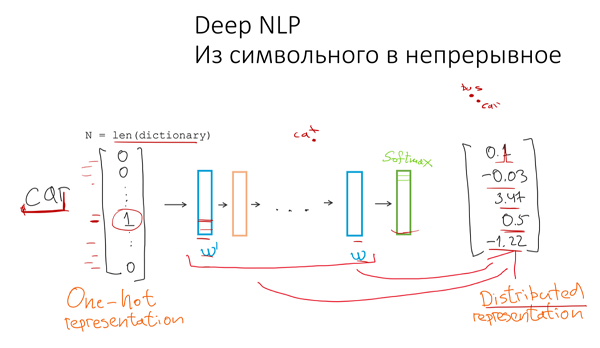

__Распредленное представление__ (Distributed representation)


<center>         
    <img src="./img/tcn_emb1_int7.png" alt="Граф зависимостей задач" style="width: 500px;"/>
    <b>Local Representation (One-hot representation)</b>
</center>
* в Local Representation (в частности one-hot) – каждое измерение соответствует отдельному объекту

<center>         
    <img src="./img/tcn_emb1_int8.png" alt="Граф зависимостей задач" style="width: 500px;"/>
    <b>Distributed Representation</b>
</center>
* в Distributed Representation – за измерениями не закреплен смысл, но расстояние между векторами несет смысловую нагрузку

Distributed representation describes the same data features across multiple scalable and interdependent layers. Each layer defines the information with the same level of accuracy, but adjusted for the level of scale. These layers are learned concurrently but in a non-linear fashion. This mimics human logic in a neural network, since each concept can be accessed by more than one neuron firing and each neuron can represent more than one concept.

Распределенное представление описывает одни и те же функции данных на нескольких масштабируемых и взаимозависимых уровнях. Каждый слой определяет информацию с одинаковым уровнем точности, но с поправкой на уровень масштаба. Эти уровни изучаются одновременно, но нелинейным образом. Это имитирует человеческую логику в нейронной сети, поскольку к каждому понятию можно получить доступ с помощью более чем одного срабатывания нейрона, и каждый нейрон может представлять более одного понятия.

* Continuous values instead of discrete 1’s and 0’s.
* Each processing unit contributes to any and all concepts.
* The representations are dense (vs. localist representations which are sparse).
* Concepts are no longer localized in one unit (hence the “distributed” designation).
* We’re able to represent a very large number of concepts with only 4 processing units (as opposed to being limited by n units to n concepts).
* We can learn new concepts without adding new units. All we need is a new configuration of values.
* __Most importantly, we are able to represent similarities better__: Large Red SUV [ 0.773 0.309 0.289 0.835 ] and Large Blue SUV [ 0.766 0.780 0.294 0.834 ] are much more similar to each other than they are to Small Fish [ 0.118 0.192 0.432 0.618 ].

__Kейс word2vec__

* Натренируем модель NN (что за модель? лучше, чтобы задача обучения без учителя!); и веса, которые соответствуют «1», будут тем самым вектором, который соответствует слову (векторным представлением слова)

<center>         
    <img src="./img/tcn_emb1_int10_3.png" alt="Граф зависимостей задач" style="width: 500px;"/>
    <b>Схематическое представление NN модели</b>
</center>

Пример модели:
* Один скрытый слой (даже без нелинейности)!
* Обучающая выборка: корпус текстов + контексты слова
* Эмбеддинг: $w(fox)=u(fox)+v(fox)$ (альтернатива: конкатенация, но вектор будет в 2 раза длиннее) 


* Базовый пример: максимизируем softmax (на самом деле не так) 

* <b class="r">Проблема:</b> знаменатель: для каждого примера нужно прогнать градиенты по всей матрице (правой)

<center>         
    <img src="./img/tcn_emb1_int11.png" alt="Граф зависимостей задач" style="width: 300px;"/>
    <b></b>
</center>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

In [14]:
# Входные данные; параметры

CONTEXT_SIZE = 2
EMBEDDING_DIM = 10

# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now

# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]


`torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False, _weight=None)`

A simple lookup table that stores embeddings of a fixed dictionary and size.

This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.

Parameters
* num_embeddings (int) – size of the dictionary of embeddings
* embedding_dim (int) – the size of each embedding vector
* и т.д. (см.: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html )


In [15]:
# Модель:

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [16]:
losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)


for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

[524.5638117790222, 522.0396604537964, 519.5338368415833, 517.0462985038757, 514.5764515399933, 512.1218264102936, 509.68100333213806, 507.2527542114258, 504.8379032611847, 502.4347949028015]


In [ ]:
torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False, _weight=None)[SOURCE]
A simple lookup table that stores embeddings of a fixed dictionary and size.

This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.

__Представление слов в виде отдельных символов__

<em class="qs"></em> Как можно представить значение слова для использования в компьютерных алгоритмах?
<em class="an"></em> Вариант решения: <em class="cb">представить слова (или другие семантические единицы) как отдельные симоволы</em>.

one-hot vectors

<em class="df"></em> One-hot представление - слово в словаре представляется в виде вектора, размер которого равен числу слов
в словаре. При этом все элементы вектора, кроме одного, равны нулю, а элемент в позиции, соответствующей номеру слова в словаре, равен единице. 
* В в векторе каждого слова единица появляется ровно по одному разу.
* На месте, где имеется единица у одного слова у всех других слов стоит 0.
* <em class="ex"/></em> 2 слова из словаря в 15 слов в one-hot представлении: 
    * motel = [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
    * hotel = [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
* One-hot представление может использоваться как для слов так и для других повторяющихся дискретных объектов в задачах машинного обучения, например букв.

Оценка one-hot представления
* <em class="pl"></em> лучше чем использование последовательных номеров, т.к. не несет очивидной семантики упорядоченности
* <em class="mn"></em> длина векторов равна размеру словаря, в большинстве случаев для слов и текстов длина вкторов становится неприемлимо велика
* <em class="mn"></em> все вектора в one-hot представлении ортоганальны, т.е. кодирование предполагает, что каждое слово одинаково (максимально) удалено ото всех других (если использовать косинусную меру близости)
<em class="hn"/></em> попытаться закондировать похожесть между словами в кодирующих их векторах и использовать одну из мер близости векторов для определения близости слов, которые они кодируют

__Косинусная мера сходства__

<em class="df"></em> __Мера сходства__ (similarity measure) - безразмерный показатель сходства сравниваемых объектов.
Большинство коэффициентов нормированы и находятся в диапазоне от 0 (сходство отсутствует) до 1 (полное сходство)

Косинус угла $\theta_{A B}$ между двумя не нулевыми векторами $\mathbf{A}$ и $\mathbf{B}$ можно получить из скалярного призведения векторов: $ \mathbf{A}\cdot\mathbf{B} =\left\|\mathbf{A}\right\|\left\|\mathbf{B}\right\|\cos\theta_{A B}$.

<em class="df"></em> Тогда __косинусная мера сходства__(cosine similarity) между $\mathbf{A}$ и $\mathbf{B}$ равна:
$$cosine\_similarity(\mathbf{A},\mathbf{B}) = \cos(\theta_{A B}) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

* косинусная мера сходства измеряет косинус угла между двумя ненулевыми векторами
* косинус 0 rad (0°) равен 1
    * <em class="hn"></em> $cosine\_similarity(\mathbf{A},\mathbf{A}) = 1$
    * $cosine\_similarity(\mathbf{A},\mathbf{B}) = 1 \nRightarrow \mathbf{A}=\mathbf{B}$
* косинус $\pi/2$ rad (90°) равен 0, косинусная мера сходства между ортоганальными векторами равна 0    
* косинус $\pi$ rad (180°) равен -1, косинусная мера сходства между противоположно направленными векторами равна 0    
* если сравниваемые вектора $\mathbf{A}$ и $\mathbf{B}$  имеют только неотрицательные компоненеты то:
    * <em class="hn"></em> угол между ними $0 \leq \theta_{A B} \leq \pi/2$
    * <em class="hn"></em> мера сходства между ними $0 \leq cosine\_similarity(\mathbf{A},\mathbf{B}) \leq 1$
    * в приложениях косинусная мера сходства часто применяется к векторам, имеющим только не отрицательные компоненты, поэтому принимается, что $0 \leq cosine\_similarity \leq 1$

Косинусная мера сходства является очень распространенной мерой в векторных пространствах. Она применятся для:
* распознавании образов
* поисковых системах
* сравнительной лингвистике
* биоинформатике, хемоинформатике
* при сравнении строк
* в биологии для количественного определения степени сходства биологических объектов 


Необходимо отметить, что косинусная мера сходства не является метрикой. 


Числовая функция $d : X \times X \to [0,\infty)$ является метрикой на множестве $X$, если 
* $d(x,y) \ge 0$ - аксиома не отрицательности
* $d(x,\;y)=0 \Leftrightarrow x=y$ - аксиома тождества
* $d(x,\;y)=d(y,\;x)$ - аксиома симметрии
* $d(x,\;z)\leqslant d(x,\;y)+d(y,\;z)$ - аксиома треугольника


* Для косинусной меры сходства выполняется только аксиома симметрии.
* Если $x$ вектора из неотрицательных компонент, то выполняется аксиома не отрицательности
* Если рассматривать вектора нормированные вектора из неотрицательных компонент то для функции $сosine\_distance=1−cosine\_similarity$ будут выполнятся все аксиомы, кроме аксиомы треугольника
* Для функции $angular\_distance = \frac{ \cos^{-1}(cosine\_similarity ) }{ \pi }$ на множестве нормированных векторов (в т.ч. и с отрицательными компонентами) будут выполнятся все акисомы метрики
* __В многих приложениях нет необходимости заменять Косинусную меру сходства на метрику углового расстояния__

__Дистрибутивная семантика__

<em class="df"></em> __Дистрибутивная гипотеза__ - лингвистические единицы, встречающиеся в схожих контекстах, имеют близкие значения
* Контексты слова - это множестов слов которые встречаются рядом с рассматриваемом словом в тексте. Для получения котнтекстов можно использовать:
    * скользящие окна фиксированной ширины
    * рассматривать в качестве границ окон, определяющих контекст, границы предложений, абзацов


__Пример: контекст слова _banking_ __
<center> 
<img src="wtv_01.png" alt="контекст слова banking" style="width: 600px;"/>
</center>

<em class="df"></em> __Дистрибутивная семантика__ - область лингвистики, которая занимается вычислением степени семантической близости между лингвистическими единицами на основании их распределения (дистрибуции) в больших массивах лингвистических данных (текстовых корпусах).
* Дистрибутивная семантика основывается на дистрибутивной гипотезе
* Дистрибутивный анализ — метод исследования языка, __основанный на изучении__ окружения (дистрибуции, распределения) отдельных единиц в __тексте (текстовом корпусе)__ и __не использующий__ сведений о полном лексическом или грамматическом __значении__ этих единиц.
* Использование дистрибутивной семантики одна из наиболее успешных идей современного NLP

Преимущества дистрибутивной семантики:
* <em class="pl"></em> выбирая корпус текстов будет создаваться семантическая модель соответствующая данному кропусу (предметной области)
* <em class="pl"></em> для создания (обучения) модели достаточно корпуса без какой-либо предварительной разметки и ручной обработки


* Каждому слову (или понятию) из словаря присваивается свой контекстный вектор
* Множество векторов формирует векторное пространство слов 
* Семантическое расстояние между словами (или понятиями) естественного языка, обычно вычисляется как косинусное расстояние между векторами вкторного пространства слов
* Для определения значения векторного представления слова (или понятия) используется множество его контекстов найденных в рассматриваемом текстовом корпусе




__Матрица совместной встречаемости__

<em class="df"></em> __Матрица совместной встречаемости__(co-occurence matrix) - матрица в которой строки соответствуют определенным сущностям и столбцы соответствуют определенным сущностям (набор сущностей для строк и столбцов можтет отличаться, тогда матрица будет прямоугольной или набор сущностей может совпадать, тогда матрица будет квадратной) - элементы матрицы неотрицательные целые числа равные количеству раз когда сущность, которой соответствует строка, и сущность, котрой соответствует столбец, совместно встречались в общем контексте.

Для нашей задачи интересны два вида матриц совместной встречаемости:
* матрица _слова_ x _документы_ (прямоугольная матрица размерности: размер словаря на количество документов в корпусе)
    * контекстом является весь документ
    * собирается информация о тематике (семантике) текстов
<center> 
__Пример матрицы совместной встречаемости теримн-документ__ (term-document)    
<img src="wtv_02.png" alt="Пример матрицы совместной встречаемости" style="width: 250px;"/>
</center>
* работа с матрицей термин-документ подробно рассматривается в рамках здачи латентного семантического анализа (Latent Semantic Analysis)


* матрица _слова_ x _слова_ (квадратная матрица размерности: размер словаря на размер словаря)
    * контекстом является скользящее окно
    * собирается информация как о семантике, так и о синтаксисе (части речи и т.п.)
<center> 
__Пример матрицы совместной встречаемости слов в документе__ (term-document)    
<img src="wtv_03.png" alt="Пример матрицы совместной встречаемости" style="width: 450px;"/>
</center>
* Пример построен для симметричного (левый и правый контекст) окна ширины 1 (обычно используется ширина 5-10) для корпуса из трех предложений:
    * I like deep learning.
    * I like NLP.
    * I enjoy ﬂying.

__Представление слов в виде векторов малой размерности__

<em class="cr">Проблемы</em> с представлением слов в виде вектора матрицы совместной встречаемости:
* <em class="mn"></em> большой размер вектора
* <em class="mn"></em> квадратичный рост хранимого объема информации при увеличении словария
* <em class="mn"></em> высокая разреженность матрицы совместной встречаемости
    * <em class="hn"></em> неэффективное хранение информации
    * <em class="hn"></em> низкая надежность использования меры сходства
    
<em class="cg">Решение:</em> построить представление слов малой размерности 
* обчно вектора малой размерности для слов имеют размерность от 25 до 1000 компонент (словари могут содержать многие десятки тысяч слов)
* вектора плотные и хранят "самую ценную" информацию т.е. мера сходства для плотных векторов в среднем должна давать близкий результат к мере сходства для векторов совместной встречаемости
* векторное представление слов назвают: "word vectors", "word embeddings", "word representations" 

<em class="qs"></em> Как уменьшить размерность векторов матрицы совместной встречаемости?

<em class="an"></em> Существует несколько методов:
* методы снижения размерности дял матриц совместной встречаемости (совместных упоминаний слов)
* построения векторов малой размероности с помощью нейронных сетей
* явные представления, обучающиеся на контекстах упоминаний слов (explicit representations)

__Сингулярное разложение__

<em class="df"></em> __Сингулярное разложение__ (Singular Value Decomposition, SVD) - разложение прямогуольной матрицы $\mathbf{M}$ вида: $\mathbf{M} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$.
* Далее будем предполагать, что исходная матрица $\mathbf{M}$ является матрицей $m \times n$ над $\mathbb{R}$ (в общем случае сингулярное разложение описывается для матриц над $\mathbb{C}$, но для упрощения мы опустим этот случай). Тогда:
* $\mathbf{U}$ ортоганальная матрица ($\mathbf{U}\mathbf{U}^{T} = \mathbf{U}^{T}\mathbf{U} = \mathbf{I}_m$) размера $m \times m$ 
* $\mathbf{V}$ ортоганальная матрица ($\mathbf{V}\mathbf{V}^{T} = \mathbf{V}^{T}\mathbf{U} = \mathbf{I}_n$) размера $n \times n$ 
* $\mathbf{\Sigma}$ диагональная прямоугольная матрица размера $m \times n$ с неотрицательными действительными числами на главной диагонали
    * элементы $\sigma_{ii}$, лежащие на главной диагонали $\mathbf{\Sigma}$ - сингулярные числа
    * неотрицательное вещественное число $\sigma$ называется __сингулярным числом__ матрицы <math>M</math> тогда и только тогда, когда существуют два вектора единичной длины $u \in \mathbb{R}^m$ и $v \in \mathbb{R}^n$ такие, что:
        * $\mathbf{M} v = \sigma u$, и $\mathbf{M}^{T} u = \sigma v$
        * векторы $u$ и $v$ называются, соответственно, __левым сингулярным вектором__ и __правым сингулярным вектором__, соответствующим сингулярному числу $\sigma$.
        * матрицы $\mathbf{U}$ и $\mathbf{V}$ состоят из левых и правых сингулярных векторов матрицы $\mathbf{M}$ соответственно

<center>  
    <img src="./img/wtv_05.png" alt="Визуализация умножений матриц в сингулярном разложении" style="width: 300px;"/>
    <strong>Визуализация умножений матриц в сингулярном разложении</strong>    
</center>

 
Пусть $r$ ($r \le min(m,n)$) ранг (максимальное число линейно независимых строк (столбцов)) матрицы $\mathbf{M}$ , тогда $\mathbf{\Sigma}=diag(\sigma_1, \dotso, \sigma_r, 0, \dotso, 0)$
* далее без ограничения общности будем считать что сингулярные значения в $\mathbf{\Sigma}$ представленны в порядке убывания, т.е. $\sigma_1$ - наибольшее сингулярное значение, а $\sigma_1$ - наименьшее сингулярное значение.
* <em class="hn"></em> сингулярное разложение можно представить как произведение матриц измененных размерностей: $\mathbf{U}_r$ размерности $m \times r$, $\mathbf{\Sigma}_r=diag(\sigma_1, \dotso, \sigma_r)$ размерности $r \times r$, $\mathbf{V}_r$ размерности $r \times n$: $\mathbf{M} = \mathbf{U}_r mathbf{\Sigma}_r \mathbf{V}_r^T$


<center>     
    <img src="./img/wtv_04.png" alt="Пример матрицы совместной встречаемости" style="width: 450px;"/>
    <strong>Пример матрицы совместной встречаемости слов в документе (term-document)</strong>
</center>

<em class="cr">Задача:</em> уменьшить размер матриц  $\mathbf{U}$, $\mathbf{\Sigma}$, $\mathbf{V}$, снизив их ранг до $k<r$ (получим $\hat{\mathbf{U}}$, $\hat{\mathbf{\Sigma}}$, $\hat{\mathbf{V}}$ с размерностями $m \times k, k \times k, k \times n$ соответственно) и при этом получить произведение $\hat{\mathbf{U}} \hat{\mathbf{\Sigma}} \hat{\mathbf{V}}^T = \hat{\mathbf{M}}$  максимально близкое к $\mathbf{M}$
* Качество приближения  $\mathbf{M}$ с помощью $\hat{\mathbf{M}}$ определим с помощью нормы Фробениуса: $\|\mathbf{M}-\hat{\mathbf{M}}\|_{\rm F} \ \rightarrow 0$
* <em class="df"></em> __Норма Фробениуса__ - $\|A\|_{\rm F} = \sqrt{\sum_{i=1}^m \sum_{j=1}^n |a_{ij}|^2}$
* Теорема Эккарта — Янга показывает, что наилучшее приближение $\hat{\mathbf{M}}$ по норме Фробениуса получится с помощью $\hat{\mathbf{\Sigma}}=mathbf{\Sigma}_k$ т.е. $\mathbf{\Sigma}_k=diag(\sigma_1, \dotso, \sigma_k)$ диагональной матрицы из наибольших сингулярных значений.

<em class="qs"></em> Как уменьшить размерность векторов матрицы совместной встречаемости?

<em class="an"></em> Использовать в качестве векторного представления слов сингулярные векторы матрицы заданного размера $k$
* <em class="mn"></em> Сложность выполнения сингулярного разложения $O(min(mn^2,m^2n))$ - это делает <em class="cr">невозможным использование сингулярного разложения</em> для получения представления слов в виде векторов малой размерности для больших матриц совместной встречаемости.
* существуют альтернативные методы приближения матрицы на основе ее факторизации, имеющие приемлемую сложность
* GloVe “Glove:	Global Vectors for Word Representation” Pennington et al. (2014) and Levy and Goldberg (2014)	

__word2vec__

Идея word2vec состоит в том, чтобы напрямую обучать вектора слов малой размерности
* A	neural	probabilis4c	language	model	(Bengio	et	al.,	2003)	
* word2vec	(Mikolov	et	al.	2013)	A	recent,	even	simpler	and	faster	model

* Faster	and	can	easily	incorporate	a	new	sentence/document	or	add	a	word	to	the	vocabulary	

Для word2vec разработаны два основных алгоритма обучения:
* CBoW (англ. Continuous Bag of Words, «непрерывный мешок со словами», bag — мультимножество)  предсказывает текущее слово, исходя из окружающего его контекста.
*  Skip-gram - использует текущее слово, чтобы предугадывать окружающие его слова. 

According to Mikolov:
* Skip-gram: 
    * works well with small amount of the training data, 
    * represents well even rare words or phrases.
* CBOW: 
    * several times faster to train than the skip-gram, 
    * slightly better accuracy for the frequent words
    
<center> 
    <img src="./img/wtv_09.png" alt="Векотры в word2vec" style="width: 450px;"/>
    <strong>Векотры в word2vec</strong>
</center>    

Эмбединнги word2vec для русского языка: https://rusvectores.org/ru/

__Модель CBOW__

Модель CBOW учится как можно лучше по заданному контексту слова восстановить само слово.
* окно для предстказания может быть любым (не обязательно предсказывать следующее слово по предыдущим), обычно предсказывают центральное слово в окне по левому и правому контексту
* по сути модель CBOW это неглубокая нейронная сеть с одним скрытым слоем

* каждый вход сети - это вектор в one-hot представлении размерности $|V|$ (размер словаря)
* в CBOW $2m$ входов: $x^{(c-m)},x^{(c-m+1)},\dotso,x^{(c-1)},x^{(c+1)},\dotso,x^{(c+m-1)},x^{(c+m)})$ ($m$ - ширина окна) и 1 выход $y^{(c)}$
* $\mathcal{V} \in \mathbb{R}^{n \times |V|}$ матрица для преобразования входных слов во внутренний слой $n$ - размерность внутреннего слоя
    *  $v_i$: i-й столбец $\mathcal{V}$
* $\mathcal{U} \in \mathbb{R}^{|V| \times n}$ матрица для проеобразования значения внутреннего слоя в выходной слой $n$ - размерность внутреннего слоя
    *  $u_i$: i-я строка $\mathcal{V}$

<center> 
    <img src="./img/wtv_07.png" alt="Схема модели CBOW" style="width: 300px;"/>
    <strong>Схема модели CBOW</strong>
</center>

Алгоритм CBOW:
1. Из контекста слова $x^{(c)}$ получается $2m$ входных векторов в one-hot представлении: $x^{(c-m)},x^{(c-m+1)},\dotso,x^{(c-1)},x^{(c+1)},\dotso,x^{(c+m-1)},x^{(c+m)})$ размерности $|V|$
2. Получаются $2m$ векторных представлений слов контекста: $v_{c-m}=\mathcal{V} x^{(c-m)},v_{c-m+1}=\mathcal{V} x^{(c-m+1)},\dotso,v_{c+m}=\mathcal{V} x^{(c+m)})$ размерности $n$
3. Расчитывается среднее векторных представлений: $\hat{v}=(v_{c-m}+v_{c-m+1}+\dotso+v_{c+m})/2m$ (значение для скрытого слоя)
4. Расчитвается вектор оценок выходного слоя $z=\mathcal{U}\hat{v}$ размерности $|V|$ (для всех слов словаря)
5. Вектор оценок преобразуется в вектор вероятностей для всех слов словаря: $\hat{y}=softmax(z)$
6. Центральное слово контекста $y^{(c)}$ one-hot вектор имеет 1 только в компоненте $i_c$, тогда модель предсказывает правильный ответ с вероятностью: $\hat{y}_{i_c}$ 

$$p(x^c|context(x^c);\theta)=\hat{y}_{i_c}=softmax(z)_{i_c}=\frac{\exp(u_{i_c}^T\hat{v})}{\sum_{j=1}^{|V|}\exp(u_{j}^T\hat{v})}$$
$\theta$ - все параметры модели: $\mathcal{V}$ и $\mathcal{U}$
$$\arg \underset{\pmb{\theta}}{\max} \prod_{c \in Text} p(x^c|context(x^c);\theta)=\arg \underset{\pmb{\theta}}{\max} \sum_{c \in Text}\ln p(x^c|context(x^c);\theta) = \arg \underset{\pmb{\theta}}{\max} \sum_{c \in Text}\ln \frac{\exp(u_{i_c}^T\hat{v})}{\sum_{j=1}^{|V|}\exp(u_{j}^T\hat{v})} = \arg \underset{\pmb{\theta}}{\max} \left ( \sum_{c \in Text} u_{i_c}^T\hat{v} - \sum_{c \in Text}\ln \sum_{j=1}^{|V|}\exp(u_{j}^T\hat{v}) \right )$$
* на каждом шаге по $c \in Text$ используется градиентный спуск для улучшения параметров $\theta$ (векторных представлений $\mathcal{V}$ и $\mathcal{U}$)
* расчет на каждом шаге слагаемого $\ln \sum_{j=1}^{|V|}\exp(u_{j}^T\hat{v})$ чрезвыйчаной трудоемок: необходимо провести суммеирование по всему словарю!

__Модель Skip-Gram__

Модель Skip-Gram учится как можно лучше по заданному слову восстановить его контекст.
* окно для предстказания может быть любым (не обязательно предсказывать следующее слово по предыдущим), обычно предсказывают контекст по центральному слову в окне.

*  вход сети - это один вектор $x^{(c)}$ в one-hot представлении размерности $|V|$ (размер словаря)
* в Skip-Gram $2m$ выходов: $y^{(c-m)},y^{(c-m+1)},\dotso,y^{(c-1)},y^{(c+1)},\dotso,y^{(c+m-1)},y^{(c+m)})$ ($m$ ширина окна) 
* $\mathcal{V} \in \mathbb{R}^{n \times |V|}$ матрица для преобразования входного слова во внутренний слой $n$ - размерность внутреннего слоя
    *  $v_i$: i-й столбец $\mathcal{V}$
* $\mathcal{U} \in \mathbb{R}^{|V| \times n}$ матрица для проеобразования значения внутреннего слоя в выходной слой $n$ - размерность внутреннего слоя
    *  $u_i$: i-я строка $\mathcal{U}$

<center> 
__Схема модели Skip-Gram__   
<img src="./img/wtv_08.png" alt="Схема модели CBOW" style="width: 300px;"/>
</center>

Алгоритм Skip-Gram:
1. Имеется один входной вектор в one-hot представлении: $x^{(c)}$
2. Из него получается значение для скрытого слоя: $\hat{v}=v_{c}=\mathcal{V} x^{(c)}$
3. Расчитвается вектор оценок выходного слоя $z=\mathcal{U}\hat{v}$ размерности $|V|$ (для всех слов словаря)
4. Вектор оценок преобразуется в вектор вероятностей для всех слов словаря: $\hat{y}=softmax(z)$
5. Для всех выходов: $y^{(c-m)},y^{(c-m+1)},\dotso,y^{(c+m)})$ для их компонент one-hot вектора $i_{c-m}, i_{c-m+1},\dotso,i_{c+m}$ извлекаются соответствующие компоненты вектора вероятностей: $\hat{y}_{i_{c-m}}, \hat{y}_{i_{c-m+1}},\dotso,\hat{y}_{i_{c+m}}$

$$p(context(x^c)|x^c;\theta)=\prod_{j=0,j\neq m}^{2m} \hat{y}_{i_(c-m+j)}=\prod_{j=0,j\neq m}^{2m} softmax(z)_{i_(c-m+j)}$$

$$\arg \underset{\pmb{\theta}}{\max} p(context(x^c)|x^c;\theta)=\arg \underset{\pmb{\theta}}{\max} \ln p(context(x^c)|x^c;\theta) = \sum_{j=0,j\neq m}^{2m} \ln softmax(z)_{i_{(c-m+j)}}=
\arg \underset{\pmb{\theta}}{\max} \sum_{j=0,j\neq m}^{2m} \ln \frac{\exp(u_{i_{(c-m+j)}}^T\hat{v})}{\sum_{j=1}^{|V|}\exp(u_{j}^T\hat{v})} =
\arg \underset{\pmb{\theta}}{\max} \sum_{j=0,j\neq m}^{2m} \ln \frac{\exp(u_{i_{(c-m+j)}}^T v_c)}{\sum_{j=1}^{|V|}\exp(u_{j}^T v_c)} =
\arg \underset{\pmb{\theta}}{\max} \left ( \sum_{j=0,j\neq m}^{2m} (u_{i_{(c-m+j)}}^T v_c) - 2m \ln \sum_{j=1}^{|V|}\exp(u_{j}^T v_c)
\right )
$$

* на каждом шаге по $c \in Text$ используется градиентный спуск для улучшения параметров $\theta$ (векторных представлений $\mathcal{V}$ и $\mathcal{U}$)
* расчет на каждом шаге слагаемого $\ln \sum_{j=1}^{|V|}\exp(u_{j}^T\hat{v})$ чрезвыйчаной трудоемок: необходимо провести суммеирование по всему словарю!
* каждое слово имеет 2 векторых представления $v_i$ и $u_i$ упростить модель за счет использования одной матриц весов (т.е. $\mathcal{U}=\mathcal{V}^T$ не получится т.к.:
    * обычно слова редко оказываются в своем контексте (например, слово "футбол" редко встречается в ближайшей окрестности слова "футбол"
    * <em class="hn"></em> модель будет минимизировать вероятнсть $p(w|w)$
    * <em class="hn"></em> модель будет минимизировать произведение $u_i^T v_i $
    * если $v_i=u_i$ это будет приводит к минимазции нормы $v_i$ для всех $i$, что очень нежелательно!

__Негативное сэмплирование__ 

__Проблема__: расчет на каждом шаге слагаемого $\sum_{j=1}^{|V|}\exp(u_{j}^T\hat{v})$ чрезвыйчаной трудоемок: необходимо провести суммеирование по всему словарю!

Идея: вместо того чтобы считать полную сумму $\sum_{j=1}^{|V|}\exp(u_{j}^T\hat{v})$ выберем несколько ее элементов случайным образом в качестве отрицательных примеров и обновим только их, то есть заменим сумму по всему словарю на гораздо более маленькую сумму $\sum_{j \in D}\exp(u_{j}^T\hat{v})$, где $D$ выбранное небольшое подмножество отрицательных примеров.

* На практике для примеров берутся слова из распределения с вероятностью равной частоте в исходном словаре

In [59]:
# https://github.com/jojonki/word2vec-pytorch/blob/master/word2vec.ipynb
# see http://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [60]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

split_ind = (int)(len(text) * 0.8)

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(text)
vocab_size = len(vocab)
print('vocab_size:', vocab_size)

w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}

vocab_size: 49


In [61]:
# context window size is two
def create_cbow_dataset(text):
    data = []
    for i in range(2, len(text) - 2):
        context = [text[i - 2], text[i - 1],
                   text[i + 1], text[i + 2]]
        target = text[i]
        data.append((context, target))
    return data

# def create_skipgram_dataset(text):
#     import random
#     data = []
#     for i in range(2, len(text) - 2):
#         data.append((text[i], text[i-2], 1))
#         data.append((text[i], text[i-1], 1))
#         data.append((text[i], text[i+1], 1))
#         data.append((text[i], text[i+2], 1))
#         # negative sampling
#         for _ in range(4):
#             if random.random() < 0.5 or i >= len(text) - 3:
#                 rand_id = random.randint(0, i-1)
#             else:
#                 rand_id = random.randint(i+3, len(text)-1)
#             data.append((text[i], text[rand_id], 0))
#     return data

cbow_train = create_cbow_dataset(text)
# skipgram_train = create_skipgram_dataset(text)
print('cbow sample', cbow_train[0])
# print('skipgram sample', skipgram_train[0])

cbow sample (['We', 'are', 'to', 'study'], 'about')


In [62]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out)
        return log_probs

In [8]:
# class SkipGram(nn.Module):
#     def __init__(self, vocab_size, embd_size):
#         super(SkipGram, self).__init__()
#         self.embeddings = nn.Embedding(vocab_size, embd_size)
    
#     def forward(self, focus, context):
#         embed_focus = self.embeddings(focus).view((1, -1))
#         embed_ctx = self.embeddings(context).view((1, -1))
#         score = torch.mm(embed_focus, torch.t(embed_ctx))
#         log_probs = F.logsigmoid(score)
    
#         return log_probs

In [52]:
embd_size = 100
learning_rate = 0.001
n_epoch = 30

def train_cbow():
    hidden_size = 64
    losses = []
    loss_fn = nn.NLLLoss()
    model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(n_epoch):
        total_loss = .0
        for context, target in cbow_train:
            ctx_idxs = [w2i[w] for w in context]
            ctx_var = Variable(torch.LongTensor(ctx_idxs))

            model.zero_grad()
            log_probs = model(ctx_var)

            loss = loss_fn(log_probs, Variable(torch.LongTensor([w2i[target]])))

            loss.backward()
            optimizer.step()

#             print(f'!!! {loss.data}')
            total_loss += loss.data.item()
        losses.append(total_loss)
    return model, losses

cbow_model, cbow_losses = train_cbow()

CBOW(
  (embeddings): Embedding(49, 100)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=49, bias=True)
)


C:\Users\alpha\.conda\envs\pyTorch_1_5v2\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [53]:
# def train_skipgram():
#     losses = []
#     loss_fn = nn.MSELoss()
#     model = SkipGram(vocab_size, embd_size)
#     print(model)
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
#     for epoch in range(n_epoch):
#         total_loss = .0
#         for in_w, out_w, target in skipgram_train:
#             in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
#             out_w_var = Variable(torch.LongTensor([w2i[out_w]]))
            
#             model.zero_grad()
#             log_probs = model(in_w_var, out_w_var)
#             loss = loss_fn(log_probs[0], Variable(torch.Tensor([target])))
            
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.data[0]
#         losses.append(total_loss)
#     return model, losses
    
# cbow_model, cbow_losses = train_cbow()
# sg_model, sg_losses = train_skipgram()

In [54]:
# test
# You have to use other dataset for test, but in this case I use training data because this dataset is too small
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))

        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted[0]]
        print('predicted:', predicted_word)
        print('label    :', target)
        if predicted_word == target:
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [55]:
# def test_skipgram(test_data, model):
#     print('====Test SkipGram===')
#     correct_ct = 0
#     for in_w, out_w, target in test_data:
#         in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
#         out_w_var = Variable(torch.LongTensor([w2i[out_w]]))

#         model.zero_grad()
#         log_probs = model(in_w_var, out_w_var)
#         _, predicted = torch.max(log_probs.data, 1)
#         predicted = predicted[0]
#         if predicted == target:
#             correct_ct += 1

#     print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

# test_cbow(cbow_train, cbow_model)
# print('------')
# test_skipgram(skipgram_train, sg_model)

In [56]:
# test
# You have to use other dataset for test, but in this case I use training data because this dataset is too small
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))

        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted[0]]
        print('predicted:', predicted_word)
        print('label    :', target)
        if predicted_word == target:
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))
    
cbow_model, cbow_losses = train_cbow()

CBOW(
  (embeddings): Embedding(49, 100)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=49, bias=True)
)


C:\Users\alpha\.conda\envs\pyTorch_1_5v2\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [57]:
# def test_skipgram(test_data, model):
#     print('====Test SkipGram===')
#     correct_ct = 0
#     for in_w, out_w, target in test_data:
#         in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
#         out_w_var = Variable(torch.LongTensor([w2i[out_w]]))

#         model.zero_grad()
#         log_probs = model(in_w_var, out_w_var)
#         _, predicted = torch.max(log_probs.data, 1)
#         predicted = predicted[0]
#         if predicted == target:
#             correct_ct += 1

#     print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

# sg_model, sg_losses = train_skipgram()    

<Figure size 432x288 with 0 Axes>

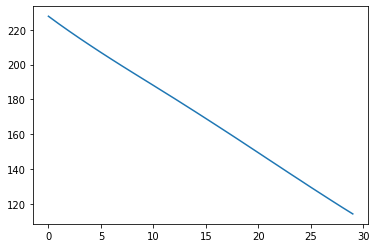

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(cbow_losses, 'CBOW Losses')
# showPlot(sg_losses, 'SkipGram Losses')

In [63]:
# processes manipulate other
target = 'manipulate'
w2i[target]

41

In [64]:
ctx[10]

NameError: name 'ctx' is not defined

In [ ]:
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))

        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted[0]]
        print('predicted:', predicted_word)
        print('label    :', target)
        if predicted_word == target:

In [79]:
ctx, target = cbow_train[13]
print(ctx, target)
ctx_idxs = [w2i[w] for w in ctx]
ctx_var = Variable(torch.LongTensor(ctx_idxs))
log_probs = cbow_model(ctx_var)

argsrt = torch.argsort(log_probs)
print(argsrt)

print(i2w[argsrt[0][-1].item()])
print(i2w[argsrt[0][-2].item()])
print(i2w[argsrt[0][-3].item()])


['are', 'abstract', 'that', 'inhabit'] beings
tensor([[43, 39, 32, 11, 30,  7, 10, 16, 42,  1,  6, 48,  4,  9,  3,  0, 29, 37,
         28, 13, 47, 18, 12, 38, 40, 45, 25, 21, 14, 19, 23,  8, 22, 46, 36, 31,
         44, 15, 27, 24, 33, 41, 34, 26,  2, 35, 20,  5, 17]])
beings
to
process


C:\Users\alpha\.conda\envs\pyTorch_1_5v2\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [72]:
i2w

{0: 'they',
 1: 'create',
 2: 'abstract',
 3: 'idea',
 4: 'In',
 5: 'to',
 6: 'evolve,',
 7: 'we',
 8: 'are',
 9: 'study',
 10: 'data.',
 11: 'computer',
 12: 'of',
 13: 'effect,',
 14: 'is',
 15: 'directed',
 16: 'People',
 17: 'beings',
 18: 'We',
 19: 'the',
 20: 'process',
 21: 'processes.',
 22: 'called',
 23: 'pattern',
 24: 'things',
 25: 'with',
 26: 'As',
 27: 'that',
 28: 'about',
 29: 'other',
 30: 'The',
 31: 'programs',
 32: 'by',
 33: 'program.',
 34: 'direct',
 35: 'a',
 36: 'computers.',
 37: 'rules',
 38: 'conjure',
 39: 'spells.',
 40: 'processes',
 41: 'manipulate',
 42: 'spirits',
 43: 'process.',
 44: 'our',
 45: 'evolution',
 46: 'inhabit',
 47: 'computational',
 48: 'Computational'}

In [65]:
ctx, target = test_data[10]
ctx, target

NameError: name 'test_data' is not defined

In [ ]:


loss = loss_fn(log_probs, Variable(torch.LongTensor([w2i[target]])))



In [ ]:

use gradient descent to update all relevant word vectors uc and
vj.



* скрытый слой сети - это фактически и есть матрица $W$ векторных представлений слов; n-я строка W содержит представление n-го слова из словаря;

the sentence represented by one-hot word vectors. The
input one hot vectors or context we will represent with an x(c). And
the output as y(c) and in the CBOW model, since we only have one
output,

• при вычислении выхода скрытого слоя мы берем просто среднее всех вход-
ных векторов; такая простота модели важна для того, чтобы в результате

предсказание
делается моделью, очень похожей на нейронную сеть; вообще, по сути word2vec —
это нейронная сеть, но неглубокая нейронная сеть, с одним скрытым уровнем


окна теперь мы
можем выбирать как захотим: нам не обязательно предсказывать следующее слово
по предыдущим, как в языковой модели, а можно, например, попытаться предска-
зать центральное слово в окне по левому и правому контексту

<math>\Sigma</math> — матрица размера <math>m \times n</math> с неотрицательными элементами, у которой элементы, лежащие на главной диагонали — это сингулярные числа (а все элементы, не лежащие на главной диагонали, являются нулевыми)

\mathbf{M} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^*

of	cooccurrence	matrix	X.		


Suppose {{math|'''M'''}} is a {{math|''m'' × ''n''}} [[matrix (mathematics)|matrix]] whose entries come from the [[field (mathematics)|field]] {{mvar|K}}, which is either the field of [[real number]]s  or the field of [[complex number]]s. Then there exists a factorization, called a 'singular value decomposition' of {{math|'''M'''}}, of the form

: <math>\mathbf{M} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^*</math>

where 
* {{math|'''U'''}} is an {{math|''m'' × ''m''}} [[unitary matrix]] over {{mvar|K}} (if {{math|''K'' {{=}} }}<math>\mathbb{R}</math>, unitary matrices are [[orthogonal matrix|orthogonal matrices]]),
* {{math|'''Σ'''}} is a [[rectangular diagonal matrix|diagonal]] {{math|''m'' × ''n''}} matrix with non-negative real numbers on the diagonal,
* {{math|'''V*'''}} is an {{math|''n'' × ''n''}} [[unitary matrix]] over {{mvar|K}}, and {{math|'''V'''<sup>∗</sup>}} is the [[conjugate transpose]] of {{math|'''V'''}}.

The diagonal entries {{mvar|σ<sub>i</sub>}} of {{math|'''Σ'''}} are known as the '''[[singular value]]s''' of {{math|'''M'''}}. A common convention is to list the singular values in descending order. In this case, the diagonal matrix, {{math|'''Σ'''}}, is uniquely determined by {{math|'''M'''}} (though not the matrices {{math|'''U'''}} and {{math|'''V'''}} if {{math|'''M'''}} is not square, see below).

__Косинусная мера сходства__

<em class="df"></em> __Мера сходства__ (similarity measure) - безразмерный показатель сходства сравниваемых объектов.

Большинство коэффициентов нормированы и находятся в диапазоне от 0 (сходство отсутствует) до 1 (полное сходство)

Косинус угла $\theta_{A B}$ между двумя не нулевыми векторами $\mathbf{A}$ и $\mathbf{B}$ можно получить из скалярного призведения векторов: $ \mathbf{A}\cdot\mathbf{B} =\left\|\mathbf{A}\right\|\left\|\mathbf{B}\right\|\cos\theta_{A B}$.

<em class="df"></em> Тогда __косинусная мера сходства__(cosine similarity) между $\mathbf{A}$ и $\mathbf{B}$ равна:
$$cosine\_similarity(\mathbf{A},\mathbf{B}) = \cos(\theta_{A B}) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

* косинусная мера сходства измеряет косинус угла между двумя ненулевыми векторами
* косинус 0 rad (0°) равен 1
    * <em class="hn"></em> $cosine\_similarity(\mathbf{A},\mathbf{A}) = 1$
    * $cosine\_similarity(\mathbf{A},\mathbf{B}) = 1 \nRightarrow \mathbf{A}=\mathbf{B}$
* косинус $\pi/2$ rad (90°) равен 0, косинусная мера сходства между ортоганальными векторами равна 0    
* косинус $\pi$ rad (180°) равен -1, косинусная мера сходства между противоположно направленными векторами равна 0    
* если сравниваемые вектора $\mathbf{A}$ и $\mathbf{B}$  имеют только неотрицательные компоненеты то:
    * <em class="hn"></em> угол между ними $0 \leq \theta_{A B} \leq \pi/2$
    * <em class="hn"></em> мера сходства между ними $0 \leq cosine\_similarity(\mathbf{A},\mathbf{B}) \leq 1$
    * в приложениях косинусная мера сходства часто применяется к векторам, имеющим только не отрицательные компоненты, поэтому принимается, что $0 \leq cosine\_similarity \leq 1$

Косинусная мера сходства применятся для:
* распознавании образов
* поисковых системах
* сравнительной лингвистике
* биоинформатике, хемоинформатике
* при сравнении строк
* в биологии для количественного определения степени сходства биологических объектов 

Необходимо отметить, что косинусная мера сходства не является метрикой. 

Метрическое пространство есть [[Пара (математика)#Упорядоченная пара|пара]] <math> (X,\;d)</math>, где <math>X</math> — 

Числовая функция $d : X \times X \to [0,\infty)$ является метрикой на множестве $X$, если 
* $d(x,y) \ge 0$ - аксиома не отрицательности
* $d(x,\;y)=0 \Leftrightarrow x=y$ - аксиома тождества
* $d(x,\;y)=d(y,\;x)$ - аксиома симметрии
* $d(x,\;z)\leqslant d(x,\;y)+d(y,\;z)$ - аксиома треугольника

* Для косинусной меры сходства выполняется только аксиома симметрии.
* Если $x$ вектора из неотрицательных компонент, то выполняется аксиома не отрицательности
* Если рассматривать вектора нормированные вектора из неотрицательных компонент то для функции $сosine\_distance=1−cosine\_similarity$ будут выполнятся все аксиомы, кроме аксиомы треугольника
* Для функции $angular\_distance = \frac{ \cos^{-1}(cosine\_similarity ) }{ \pi }$ на множестве нормированных векторов (в т.ч. и с отрицательными компонентами) будут выполнятся все акисомы метрики
* __В многих приложениях нет необходимости заменять Косинусную меру сходства на метрику углового расстояния__

Векторное представление (word embedding) - общее название для различных подходов к моделированию языка и обучению представлений в обработке естественного языка, направленных на сопоставление словам (иногда и другим единицам текста) из некоторого словаря векторов из $n$ мерного простарнства $\mathbb{R}^n$, где $n$ значительно меньше количества слов в словаре. 

Использование этого подхода базируется на __дистрибутивной гипотезе__: лингвистические единицы, встречающиеся в схожих контекстах, имеют близкие значения.






Существует несколько методов для построения такого сопоставления. Так, используют нейронные сети[1] , методы снижения размерности в применении к матрицам совместных упоминаний слов (word co-occurrence matrices)[2] и явные представления, обучающиеся на контекстах упоминаний слов (explicit representations)[3].

Продемонстрировано[кем?], что векторные представления слов и фраз способны значительно улучшить качество работы некоторых методов автоматической обработки естественного языка (например, синтаксический анализ[4] и анализ тональности[5]).

https://rusvectores.org/ru/#

Векторное представление — общее название для различных подходов к моделированию языка и обучению представлений в обработке естественного языка, направленных на сопоставление словам (и, возможно, фразам) из некоторого словаря векторов из {\displaystyle \mathbb {R} ^{n}} \R^{n} для {\displaystyle n} n, значительно меньшего количества слов в словаре. Теоретической базой для векторных представлений является дистрибутивная семантика.

Существует несколько методов для построения такого сопоставления. Так, используют нейронные сети[1] , методы снижения размерности в применении к матрицам совместных упоминаний слов (word co-occurrence matrices)[2] и явные представления, обучающиеся на контекстах упоминаний слов (explicit representations)[3].

Продемонстрировано[кем?], что векторные представления слов и фраз способны значительно улучшить качество работы некоторых методов автоматической обработки естественного языка (например, синтаксический анализ[4] и анализ тональности[5]).

екторного представления слов (word 
embeddings). В отличие от векторов, полученных прямым кодированием, — би-
нарных, разреженных (почти полностью состоящих из нулей) и с большой раз-
мерностью (их размерность совпадает с количеством слов в словаре) — векторные 
представления слов являются малоразмерными векторами вещественных чисел 
(то есть плотными векторами, в противоположность разреженным), как показано 
на рис. 6.2. В отличие от векторов, полученных прямым кодированием, векторные 
представления слов конструируются из данных. При работе с огромными словаря-
ми размерность векторов слов нередко может достигать 256,

<br/> next <em class="qs"/> qs line 
<br/> next <em class="an"/> an line 
<br/> next <em class="nt"/> an line 
<br/> next <em class="df"/> df line 
<br/> next <em class="ex"/> ex line 
<br/> next <em class="pl"/> pl line 
<br/> next <em class="mn"/> mn line 
<br/> next <em class="plmn"/> plmn line 
<br/> next <em class="hn"/> hn line 